In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from time import sleep 

from torchvision import datasets
import torchvision.transforms as transforms

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim 

In [2]:
torch.cuda.is_available()

True

In [40]:
train_dataset = datasets.CIFAR10(root = "cifar/", train = True, download = False, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "cifar/", train = False, download = False, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = True, pin_memory=True)

In [41]:
def train(model, optimizer, dataloader):
    for x,y in dataloader:
        x, y = x.to('cuda:0'), y.to('cuda:0')
        optimizer.zero_grad()
        prediction = model.forward(x)

        loss = nn.CrossEntropyLoss()
        output_loss = loss(prediction, y)
        output_loss.backward()
        optimizer.step()
    return output_loss

def accuracy(model, dataloader):
    hits = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to('cuda:0'), y.to('cuda:0')
            prediction = model.forward(x)
            prediction = torch.argmax(prediction, dim=1)
            hits += (prediction == y).count_nonzero()
    acc = hits / len(dataloader.dataset)
    return acc

In [42]:
class Network_FC(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.bn1 = nn.BatchNorm1d(512, affine=True)
        self.bn2 = nn.BatchNorm1d(512, affine=True)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = x.reshape(-1, 32*32*3)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def forward_test(self, x):
        x = x.reshape(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [43]:
def train_fc(model, optimizer, dataloader, batch:bool):
    for x, y in dataloader:
        x, y = x.to('cuda:0'), y.to('cuda:0')
        optimizer.zero_grad()
        if batch == True:
            prediction = model.forward(x)
        else: 
            prediction = model.forward_test(x)
        loss = nn.CrossEntropyLoss()
        output_loss = loss(prediction, y.to(torch.long))
        output_loss.backward()
        optimizer.step()
    return output_loss

def accuracy_fc(model, dataloader):
    hits = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to('cuda:0'), y.to('cuda:0')
            prediction = model.forward_test(x)
            prediction = torch.argmax(prediction, dim=1)
            hits += (prediction == y).count_nonzero()
    acc = hits / len(dataloader.dataset)
    return acc

In [44]:
def batch_norm(model_factory, optimizer_factory, dataloader, epochs):
    losses = torch.zeros(epochs)
    accuracies = torch.zeros(epochs)
    model = model_factory.to('cuda:0')
    optimizer = optimizer_factory
    for epoch in tqdm(range(epochs)):
        losses[epoch] = train_fc(model, optimizer, dataloader, True)
        accuracies[epoch] = accuracy_fc(model, test_loader)
        print(f"The loss of {epoch} is {losses[epoch]}")
        print(f"The accuracy of {epoch} is {accuracies[epoch]}")
        sleep(0.1)
    return losses, accuracies

In [45]:
model1 = Network_FC()
optimizer1  = optim.Adam(model1.parameters(), lr= 0.0005, betas= (0.9, 0.95))
batch_losses, batch_accuracies = batch_norm(model1, optimizer1, train_loader, 25)

  4%|▍         | 1/25 [00:04<01:55,  4.79s/it]

The loss of 0 is 1.4370720386505127
The accuracy of 0 is 0.14800000190734863


  8%|▊         | 2/25 [00:09<01:51,  4.84s/it]

The loss of 1 is 1.2571609020233154
The accuracy of 1 is 0.1525999903678894


 12%|█▏        | 3/25 [00:14<01:47,  4.89s/it]

The loss of 2 is 1.200891375541687
The accuracy of 2 is 0.15649999678134918


 16%|█▌        | 4/25 [00:19<01:42,  4.86s/it]

The loss of 3 is 1.1383662223815918
The accuracy of 3 is 0.15600000321865082


 20%|██        | 5/25 [00:24<01:37,  4.87s/it]

The loss of 4 is 1.1768920421600342
The accuracy of 4 is 0.13159999251365662


 24%|██▍       | 6/25 [00:29<01:32,  4.86s/it]

The loss of 5 is 0.868902325630188
The accuracy of 5 is 0.11339999735355377


 28%|██▊       | 7/25 [00:34<01:27,  4.84s/it]

The loss of 6 is 0.9044333696365356
The accuracy of 6 is 0.2223999947309494


 32%|███▏      | 8/25 [00:38<01:22,  4.86s/it]

The loss of 7 is 0.7373915910720825
The accuracy of 7 is 0.13189999759197235


 36%|███▌      | 9/25 [00:43<01:17,  4.86s/it]

The loss of 8 is 0.8337219953536987
The accuracy of 8 is 0.18959999084472656


 40%|████      | 10/25 [00:48<01:12,  4.81s/it]

The loss of 9 is 0.5552576780319214
The accuracy of 9 is 0.1809999942779541


 44%|████▍     | 11/25 [00:53<01:07,  4.80s/it]

The loss of 10 is 0.6842232346534729
The accuracy of 10 is 0.11789999902248383


 48%|████▊     | 12/25 [00:58<01:02,  4.80s/it]

The loss of 11 is 0.6714627146720886
The accuracy of 11 is 0.23729999363422394


 52%|█████▏    | 13/25 [01:02<00:57,  4.78s/it]

The loss of 12 is 0.6028063893318176
The accuracy of 12 is 0.18150000274181366


 56%|█████▌    | 14/25 [01:07<00:52,  4.78s/it]

The loss of 13 is 0.6381157040596008
The accuracy of 13 is 0.15629999339580536


 60%|██████    | 15/25 [01:12<00:47,  4.77s/it]

The loss of 14 is 0.6121333241462708
The accuracy of 14 is 0.15109999477863312


 64%|██████▍   | 16/25 [01:17<00:42,  4.74s/it]

The loss of 15 is 0.43031033873558044
The accuracy of 15 is 0.12860000133514404


 68%|██████▊   | 17/25 [01:21<00:37,  4.72s/it]

The loss of 16 is 0.536955714225769
The accuracy of 16 is 0.2052999883890152


 72%|███████▏  | 18/25 [01:26<00:32,  4.71s/it]

The loss of 17 is 0.39139771461486816
The accuracy of 17 is 0.17249999940395355


 76%|███████▌  | 19/25 [01:31<00:28,  4.75s/it]

The loss of 18 is 0.33545058965682983
The accuracy of 18 is 0.2255999892950058


 80%|████████  | 20/25 [01:36<00:23,  4.76s/it]

The loss of 19 is 0.30182334780693054
The accuracy of 19 is 0.1914999932050705


 84%|████████▍ | 21/25 [01:40<00:18,  4.75s/it]

The loss of 20 is 0.30502521991729736
The accuracy of 20 is 0.21289999783039093


 88%|████████▊ | 22/25 [01:45<00:14,  4.72s/it]

The loss of 21 is 0.2944647967815399
The accuracy of 21 is 0.2345999926328659


 92%|█████████▏| 23/25 [01:50<00:09,  4.72s/it]

The loss of 22 is 0.2116018533706665
The accuracy of 22 is 0.1664000004529953


 96%|█████████▌| 24/25 [01:54<00:04,  4.71s/it]

The loss of 23 is 0.12682011723518372
The accuracy of 23 is 0.18389999866485596


100%|██████████| 25/25 [01:59<00:00,  4.78s/it]

The loss of 24 is 0.2463037222623825
The accuracy of 24 is 0.2320999950170517


In [46]:
class Network_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)

        x = torch.randn(32,32,3).view(-1,3,32,32)
        
        self._to_linear = None 
        self.convs(x)
        
        self.fc = nn.Linear(self._to_linear, 10)
        
    def convs(self,x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x , (2,2))
        
        #Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x , (2,2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc(x)
        return x

In [47]:
def training(model_factory, dataloader, optimizer_factory, epochs):
    losses = torch.zeros(epochs)
    accuracies = torch.zeros(epochs)
    model = model_factory.to('cuda:0')
    optimizer = optimizer_factory
    
    for epoch in tqdm(range(epochs)):
        losses[epoch] = train(model, optimizer, dataloader)
        accuracies[epoch] = accuracy(model, test_loader)
        print(f"The loss of {epoch} is {losses[epoch]}")
        print(f"The accuracy of {epoch} is {accuracies[epoch]}")
        sleep(0.1)
    return losses, accuracies

In [48]:
model = Network_CNN()
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95))
losses, accuracies = training(model, train_loader, optimizer, 25) 

  4%|▍         | 1/25 [00:04<01:59,  4.99s/it]

The loss of 0 is 1.3572357892990112
The accuracy of 0 is 0.42729997634887695


  8%|▊         | 2/25 [00:10<01:56,  5.07s/it]

The loss of 1 is 1.547735333442688
The accuracy of 1 is 0.48539999127388


 12%|█▏        | 3/25 [00:15<01:51,  5.06s/it]

The loss of 2 is 1.3679765462875366
The accuracy of 2 is 0.5026000142097473


 16%|█▌        | 4/25 [00:20<01:47,  5.14s/it]

The loss of 3 is 1.1652354001998901
The accuracy of 3 is 0.5508999824523926


 20%|██        | 5/25 [00:26<01:44,  5.24s/it]

The loss of 4 is 1.3515493869781494
The accuracy of 4 is 0.5888000130653381


 24%|██▍       | 6/25 [00:31<01:39,  5.24s/it]

The loss of 5 is 1.195068359375
The accuracy of 5 is 0.6176999807357788


 28%|██▊       | 7/25 [00:36<01:35,  5.32s/it]

The loss of 6 is 1.0707569122314453
The accuracy of 6 is 0.6270999908447266


 32%|███▏      | 8/25 [00:42<01:31,  5.37s/it]

The loss of 7 is 1.0532087087631226
The accuracy of 7 is 0.655299961566925


 36%|███▌      | 9/25 [00:47<01:27,  5.45s/it]

The loss of 8 is 0.8564445376396179
The accuracy of 8 is 0.65829998254776


 40%|████      | 10/25 [00:53<01:21,  5.43s/it]

The loss of 9 is 0.7977771759033203
The accuracy of 9 is 0.6750999689102173


 44%|████▍     | 11/25 [00:58<01:16,  5.43s/it]

The loss of 10 is 1.005976915359497
The accuracy of 10 is 0.6883999705314636


 48%|████▊     | 12/25 [01:04<01:09,  5.37s/it]

The loss of 11 is 0.6366170644760132
The accuracy of 11 is 0.6876999735832214


 52%|█████▏    | 13/25 [01:09<01:04,  5.34s/it]

The loss of 12 is 0.8140770792961121
The accuracy of 12 is 0.6991999745368958


 56%|█████▌    | 14/25 [01:14<00:58,  5.35s/it]

The loss of 13 is 0.9962908029556274
The accuracy of 13 is 0.6935999989509583


 60%|██████    | 15/25 [01:19<00:53,  5.33s/it]

The loss of 14 is 0.8851415514945984
The accuracy of 14 is 0.6940999627113342


 64%|██████▍   | 16/25 [01:25<00:47,  5.26s/it]

The loss of 15 is 0.7928289771080017
The accuracy of 15 is 0.708299994468689


 68%|██████▊   | 17/25 [01:30<00:41,  5.23s/it]

The loss of 16 is 0.6501529216766357
The accuracy of 16 is 0.6994999647140503


 72%|███████▏  | 18/25 [01:35<00:36,  5.23s/it]

The loss of 17 is 0.7705351114273071
The accuracy of 17 is 0.7215999960899353


 76%|███████▌  | 19/25 [01:40<00:31,  5.24s/it]

The loss of 18 is 0.7686651945114136
The accuracy of 18 is 0.717199981212616


 80%|████████  | 20/25 [01:45<00:25,  5.16s/it]

The loss of 19 is 0.8675413131713867
The accuracy of 19 is 0.7185999751091003


 84%|████████▍ | 21/25 [01:50<00:20,  5.10s/it]

The loss of 20 is 0.7024703025817871
The accuracy of 20 is 0.7289999723434448


 88%|████████▊ | 22/25 [01:55<00:15,  5.10s/it]

The loss of 21 is 0.7300859689712524
The accuracy of 21 is 0.7289999723434448


 92%|█████████▏| 23/25 [02:00<00:10,  5.09s/it]

The loss of 22 is 0.6364946961402893
The accuracy of 22 is 0.7324000000953674


 96%|█████████▌| 24/25 [02:05<00:05,  5.05s/it]

The loss of 23 is 0.46874842047691345
The accuracy of 23 is 0.7330999970436096


100%|██████████| 25/25 [02:10<00:00,  5.23s/it]

The loss of 24 is 0.6471379399299622
The accuracy of 24 is 0.7287999987602234


In [49]:
def plotting_losses(cnn, fc):
    plt.plot(cnn.detach(), 'r', label="CNN")
    plt.plot(fc.detach(), 'k', label="Dense")
    plt.legend()
    plt.show()
    
def acc_plot(cnn, fc):
    plt.plot(cnn, 'r', label="CNN")
    plt.plot(fc, 'k', label="Dense")
    plt.legend()
    plt.show()

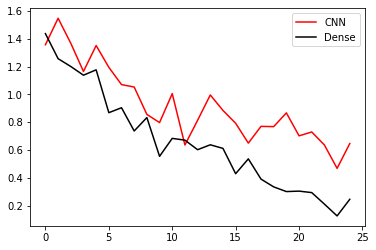

In [50]:
plotting_losses(losses, batch_losses)

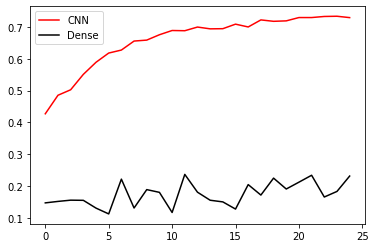

In [51]:
acc_plot(accuracies, batch_accuracies)

There is definitely a lot of improvement in the accuracies. This time again we saw that the accuracies were very low for the batch normalized network. Although the losses are considerbly lower but the accuracies don't increase. This needs some investigation

The new CNN model is better suited because CNN does not destroy the spatial features of the image, it takes in the images as 2D tensor instead of flatted 1D tensor in baseline network.